In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import re
import nltk
import jieba
import spacy
import string
import emoji
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import StepLR
from IPython.display import FileLink
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
if torch.cuda.is_available():
    print("CUDA is available. You have GPU support.")
else:
    print("CUDA is not available. You do not have GPU support.")

CUDA is available. You have GPU support.


# Load Pikle file for Preprocessed Dataframe

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/translation/other/translation/1/preprocessed_translation_val_set_mBERT.pkl
/kaggle/input/translation/other/translation/1/preprocessed_translation_trainset_mBERT.pkl
/kaggle/input/translation/other/translation/1/preprocessed_translation_testset_mBERT.pkl
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/MangolianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/IrishTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/HindiTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/PersianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/UrduTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/GeorgianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-datas

In [4]:
preprocessed_trainset = pd.read_pickle('/kaggle/input/translation/other/translation/1/preprocessed_translation_trainset_mBERT.pkl')
preprocessed_valset = pd.read_pickle('/kaggle/input/translation/other/translation/1/preprocessed_translation_val_set_mBERT.pkl')
preprocessed_testset = pd.read_pickle('/kaggle/input/translation/other/translation/1/preprocessed_translation_testset_mBERT.pkl')

In [5]:
preprocessed_trainset

,text,label,cleaned_text
211160,USER is dead and the dealer has gone bankrupt,1.0,dead dealer go bankrupt
42468,RT @MaghrebiHD: This is for all the imbeciles ...,1.0,imbecile think united nation institution relat...
30596,Russia bombs Syria 's Palmyra after fresh IS a...,0.0,russia bomb syria palmyra fresh advance middle...
13176,RT @swin24: ISIS is gonna use Pokemon Go again...,0.0,isi gon na use pokemon go u isnt
25119,https://www.washingtonpost.com/world/national...,0.0,double game even battle isi turkey give extrem...
...,...,...,...
41355,@realDonaldTrump Only Criminals and ISIS Affil...,0.0,criminal isi affiliate would vote mass murdere...
10426,#WilayatArRaqqah #Photo #Report 3: #Duties of ...,1.0,wilayatarraqqah photo report duty agriculture ...
62398,Because it doesn’t hurt unless the knife pierc...,1.0,’ hurt unless knife pierce one ’ body man jump...
5021,#News Islamic State rapidly losing ground in I...,0.0,news islamic state rapidly lose ground iraq sy...


In [6]:
preprocessed_valset

,text,label,cleaned_text
62610,Totally agree. The sad reality is that often o...,0.0,totally agree sad reality often one gangster d...
58015,"I am anti-marriage, so what? What crime can yo...",1.0,antimarriage crime add girl please see clearly...
32152,"Is this act of Saudi Islamic? If not, where ar...",1.0,act saudi islamic scholar condemn saudi critic...
49803,You are generalizing too much. Christian peopl...,0.0,generalize much christian people also know rap...
17607,Muslim 's ugly encounter leads to apology http...,0.0,muslim ugly encounter lead apology
...,...,...,...
42792,"As Daesh lose territory, how will they react? ...",0.0,daesh lose territory react interesting questio...
212027,USER ccd ceced? what are you up to?,1.0,ccd ceced
26985,RT @RamiAlLolah: #YPG terror group has killed ...,1.0,ypg terror group kill young boy protest peacef...
212194,"""Come on, Alex, don't be a villager..."" he mut...",1.0,come alex dont villager mutter curse himselfnn...


In [7]:
preprocessed_testset

,text,label,cleaned_text
141059,RT @warreports: 8 Pakistanis of #IRGC 's Zeyna...,1.0,pakistani irgc zeynabiun brigade kill north sy...
6108,gronk tide pod commercial retarded,1.0,gronk tide pod commercial retard
108845,@sfrantzman @pmakela1 what they found in Syria...,0.0,find syria lot weapon wwii gun shop isi lot ir...
126712,After Pakistani Taliban announcement of their ...,0.0,pakistani taliban announcement support isi lin...
127530,Good luck getting our attention this week ISIS...,0.0,good luck get attention week isi pokemongo
...,...,...,...
242973,There are many other issues that apply to Musl...,0.0,many issue apply muslim lgbt say personal sin ...
232643,"Teach Muslims, religion does not teach killing...",1.0,teach muslims religion teach kill understand i...
234679,"Bismillah,; superiorPRINTING;; Price; Retail :...",0.0,bismillah superiorprinting price retail lgnpla...
243574,Full Name : Iris Jung\n\nReal Name : Jung An R...,0.0,full name iris jungnnreal name jung rinnplace ...


# Training mBERT

In [8]:
# Load pre-trained mBERT uncased model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Define hyperparameters
learning_rate = 2e-5
batch_size = 32
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
patience=3
min_delta=0.001
save_path = 'mBERT_over.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

In [9]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [10]:
# # Tokenize, pad, and convert your dataset
# texts = list(oversampled['text'])
# labels = list(oversampled['label'])

# input_ids = []
# attention_masks = []

# for text in texts:
#     encoded = tokenizer.encode_plus(
#         text,
#         add_special_tokens=True,
#         max_length=128,  # Set your desired sequence length
#         padding='max_length',
#         truncation=True,
#         return_tensors='pt',
#     )


#     input_ids.append(encoded['input_ids'])
#     attention_masks.append(encoded['attention_mask'])

# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

In [11]:
# def textDataset(dataframe, tokenizer, max_length=256):
#     """
#     Preprocess text data for transformer-based models.
#     """
#     texts = list(dataframe['cleaned_text'])
#     labels = list(dataframe['label'])

#     input_ids = []
#     attention_masks = []

#     for text in texts:
#         encoded = tokenizer.encode_plus(
#             text,
#             add_special_tokens=True,
#             max_length=max_length,
#             padding='max_length',
#             truncation=True,
#             return_attention_mask=True
#         )
#         input_ids.append(encoded['input_ids'])
#         attention_masks.append(encoded['attention_mask'])

#     # Convert lists to tensors
#     input_ids = torch.cat(input_ids, dim=0)
#     attention_masks = torch.cat(attention_masks, dim=0)
#     labels = torch.tensor(labels)

#     # Create a TensorDataset
#     dataset = TensorDataset(input_ids, attention_masks, labels)
#     return dataset

In [12]:
def textDataset(dataframe, tokenizer, max_length=256):
    """
    Preprocess text data for transformer-based models, ensuring that only valid entries are processed.
    """
    # Filter the DataFrame to remove any rows with NaN values in 'cleaned_text' or 'label'
    dataframe = dataframe.dropna(subset=['cleaned_text', 'label'])

    texts = list(dataframe['cleaned_text'])
    labels = list(dataframe['label'])

    input_ids = []
    attention_masks = []

    # Process each text entry in the DataFrame
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)

    # Create a TensorDataset
    dataset = TensorDataset(input_ids, attention_masks, labels)
    return dataset

In [13]:
train_dataset = textDataset(preprocessed_trainset, tokenizer)
val_dataset = textDataset(preprocessed_valset, tokenizer)
test_dataset = textDataset(preprocessed_testset, tokenizer)

In [14]:
# Create DataLoader objects for training, validation, and testing
train_dataloader      = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader       = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * num_epochs
)

In [16]:
def validate_model(model, epoch, val_loader, device, num_epochs):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Val)'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device, dtype=torch.long)

            outputs = model(input_ids, attention_mask=attention_mask, labels = labels)
            logits = outputs.logits

            loss = outputs.loss
            total_loss += loss.item()

            predicted = torch.argmax(logits, dim=1).cpu().numpy()
            labels_numpy = labels.cpu().numpy()  # Convert labels to NumPy array

            total += len(labels_numpy)  # Update total with the batch size
            correct += (predicted == labels_numpy).sum()  

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [17]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, scheduler, device, save_path):
#     model.to(device)

#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []
#     best_val_loss = float('inf')  # Initialize best validation loss to a large number

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss, total, correct = 0, 0, 0

#         for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)'):
#             input_ids, attention_mask, labels = batch
#             input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device, dtype=torch.long)

#             optimizer.zero_grad()

#             # Get the model outputs
#             outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

#             # Extract logits from the model outputs
#             logits = outputs.logits

#             # Calculate loss using the extracted logits
# #             loss = criterion(logits, labels)
#             loss = outputs.loss

#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#             # Predictions for calculating accuracy (assuming binary classification)
#             predicted = torch.argmax(logits, dim=1).cpu().numpy()
#             labels_numpy = labels.cpu().numpy()  # Convert labels to NumPy array

#             total += len(labels_numpy)  # Update total with the batch size
#             correct += (predicted == labels_numpy).sum()  # Correct is incremented by the sum of correct predictions 

#         train_avg_loss = total_loss / len(train_loader)
#         train_accuracy = 100 * correct / total
#         train_losses.append(train_avg_loss)
#         train_accuracies.append(train_accuracy)

#         # Validate the model
#         val_avg_loss, val_accuracy = validate_model(model, epoch, val_loader, criterion, device, num_epochs)
#         val_losses.append(val_avg_loss)
#         val_accuracies.append(val_accuracy)

#         # Save the model if it has the best validation loss so far
#         if val_avg_loss < best_val_loss:
#             best_val_loss = val_avg_loss
#             torch.save(model.state_dict(), save_path)
#             print(f'Model saved: Epoch {epoch+1} with Val Loss: {val_avg_loss:.4f}')

#         scheduler.step()

#         print(f'End of Epoch {epoch+1}, Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

#     return train_losses, train_accuracies, val_losses, val_accuracies

In [18]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler, device, patience, min_delta, save_path):
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    early_stopping_counter = 0  # Initialize the counter for early stopping

    for epoch in range(num_epochs):
        model.train()
        total_loss, total, correct = 0, 0, 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} (Train)'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels_numpy = labels.cpu().numpy()
            total += len(labels_numpy)
            correct += (predicted == labels_numpy).sum()

        train_avg_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_avg_loss)
        train_accuracies.append(train_accuracy)

        val_avg_loss, val_accuracy = validate_model(model, epoch, val_loader, device, num_epochs)
        val_losses.append(val_avg_loss)
        val_accuracies.append(val_accuracy)

        print(f'End of Epoch {epoch+1}, Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping logic
        if val_avg_loss < best_val_loss - min_delta:
            best_val_loss = val_avg_loss
            torch.save(model.state_dict(), save_path)
            print(f'Model saved: Epoch {epoch+1} with Val Loss: {val_avg_loss:.4f}')
            early_stopping_counter = 0  # Reset counter
        else:
            early_stopping_counter += 1
            print(f"No improvement in validation loss for {early_stopping_counter} epochs.")
            if early_stopping_counter >= patience:
                print(f"Stopping early at epoch {epoch+1}")
                break

        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies

In [19]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_dataloader, validation_dataloader, optimizer, num_epochs, scheduler, device, patience, min_delta, save_path='mBERT_translation.pth' )

Epoch 1/10 (Val): 100%|██████████| 685/685 [02:49<00:00,  4.03it/s]


End of Epoch 1, Train Loss: 0.3705, Train Accuracy: 82.85%, Val Loss: 0.3038, Val Accuracy: 86.86%
Model saved: Epoch 1 with Val Loss: 0.3038


Epoch 2/10 (Val): 100%|██████████| 685/685 [02:49<00:00,  4.03it/s]


End of Epoch 2, Train Loss: 0.2686, Train Accuracy: 88.38%, Val Loss: 0.2717, Val Accuracy: 88.17%
Model saved: Epoch 2 with Val Loss: 0.2717


Epoch 3/10 (Val): 100%|██████████| 685/685 [02:49<00:00,  4.03it/s]


End of Epoch 3, Train Loss: 0.2054, Train Accuracy: 91.32%, Val Loss: 0.3010, Val Accuracy: 88.13%
No improvement in validation loss for 1 epochs.


Epoch 4/10 (Val): 100%|██████████| 685/685 [02:49<00:00,  4.03it/s]


End of Epoch 4, Train Loss: 0.1552, Train Accuracy: 93.54%, Val Loss: 0.3149, Val Accuracy: 88.29%
No improvement in validation loss for 2 epochs.


Epoch 5/10 (Val): 100%|██████████| 685/685 [02:49<00:00,  4.03it/s]

End of Epoch 5, Train Loss: 0.1159, Train Accuracy: 95.24%, Val Loss: 0.3796, Val Accuracy: 87.28%
No improvement in validation loss for 3 epochs.
Stopping early at epoch 5


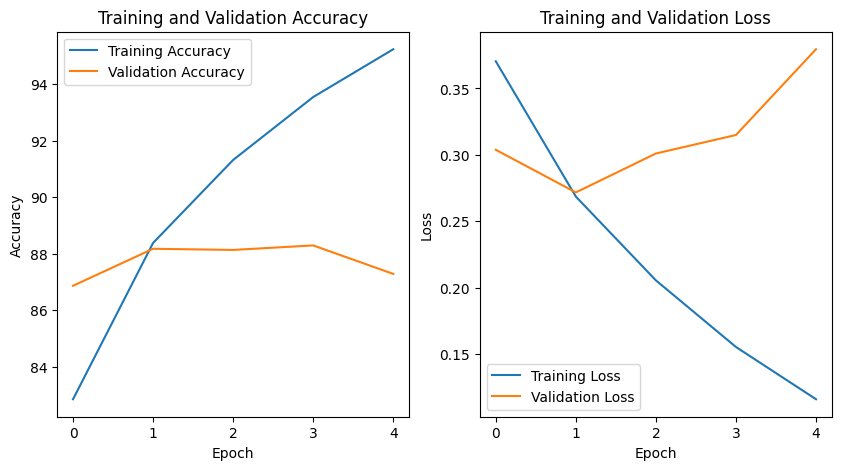

In [20]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
# model file link
FileLink(r'mBERT_translation.pth')

/kaggle/working/mBERT_translation.pth

# Evaluation

In [22]:
def evaluate_model(model, dataloader, device):
    """
    Evaluate the given model using the provided dataloader, calculating and plotting
    confusion matrix and ROC curve.
    """
    model.eval()
    model = model.to(device)

    test_preds = []
    test_true = []
    probs_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluation'):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            true = labels.cpu().numpy()
            probs = logits.softmax(dim=1).cpu().numpy()  # For binary, [:, 1], for multi-class keep probabilities

            test_preds.extend(preds)
            test_true.extend(true)
            probs_list.extend(probs)

    # Metrics calculation
    accuracy = accuracy_score(test_true, test_preds)
    precision = precision_score(test_true, test_preds, average='weighted')
    recall = recall_score(test_true, test_preds, average='weighted')
    f1 = f1_score(test_true, test_preds, average='weighted')
    classification_rep = classification_report(test_true, test_preds)

    # Confusion matrix
    cm = confusion_matrix(test_true, test_preds)

    # ROC Curve - assuming binary classification
    fpr, tpr, thresholds = roc_curve(test_true, [p[1] for p in probs_list], pos_label=1)
    roc_auc = auc(fpr, tpr)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(classification_rep)

    return accuracy, precision, recall, f1, classification_rep, cm, fpr, tpr,roc_auc

In [23]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)

model.load_state_dict(torch.load('mBERT_translation.pth'))

accuracy, precision, recall, f1, classification_rep, cm, fpr, tpr,roc_auc = evaluate_model(model, test_dataloader, device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluation: 100%|██████████| 252/252 [01:02<00:00,  4.04it/s]


Accuracy: 0.8838
Precision: 0.8853
Recall: 0.8838
F1-Score: 0.8841
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90      4547
         1.0       0.85      0.89      0.87      3501

    accuracy                           0.88      8048
   macro avg       0.88      0.88      0.88      8048
weighted avg       0.89      0.88      0.88      8048



## Confusion Matrix

In [24]:
def plot_confusion_matrix(conf_matrix, class_labels):
    """
    Plots a confusion matrix using seaborn's heatmap with percentages and TP, TN, FP, FN annotations.
    """
    # Calculate the percentage of each confusion entry
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create annotations that include both count and percentage, and classification (TP, TN, FP, FN)
    annotations = np.empty_like(conf_matrix).astype(str)
    nrows, ncols = conf_matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = conf_matrix[i, j]
            p = conf_matrix_percent[i, j] * 100
            if i == 0 and j == 0:
                label = "TN"
            elif i == 0 and j == 1:
                label = "FP"
            elif i == 1 and j == 0:
                label = "FN"
            elif i == 1 and j == 1:
                label = "TP"
            annotations[i, j] = f"{label}\n{c}\n({p:.1f}%)"

    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=annotations, fmt='', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

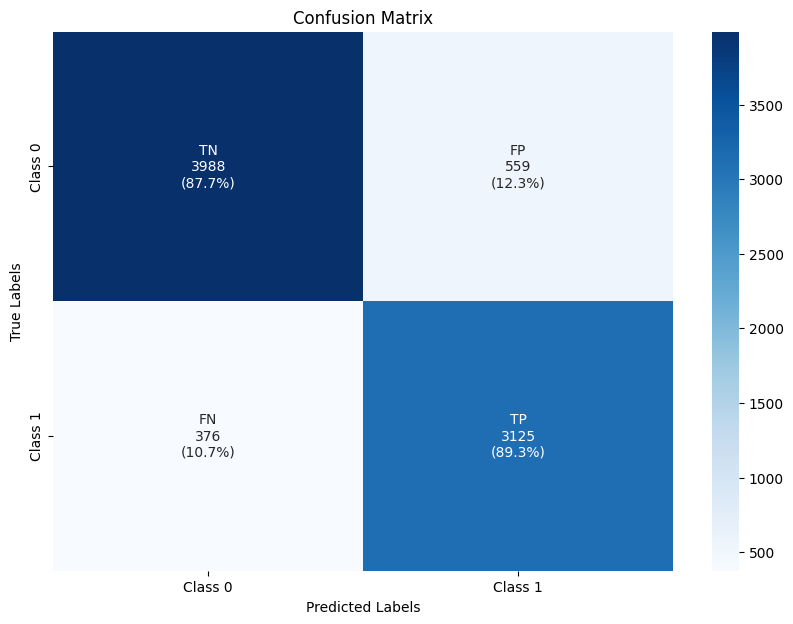

In [25]:
plot_confusion_matrix(cm, class_labels=['Class 0', 'Class 1'])

## ROC

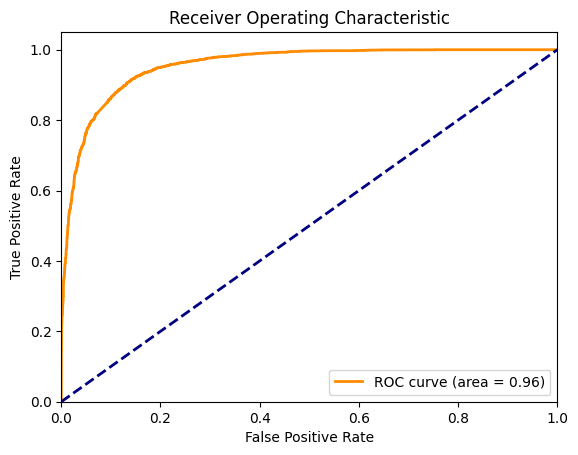

In [26]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
# import pickle
# pickle.dump(model, open('mBERT_model.pkl', 'wb'))